## import libraries

In [3]:
import cv2 as cv
import numpy as np
import pytesseract as pt

import matplotlib.pyplot as plt

import fitz

import os
import numpy as np
from PIL import Image
from fpdf import FPDF
# from PyPDF2 import PdfReader

## image preprocessing

In [5]:
def pre_process(img):
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret,thresh = cv.threshold(gray_image, 0, 255, cv.THRESH_OTSU | cv.THRESH_BINARY_INV)

    #dilation
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (14, 14))

    # Applying dilation on the threshold image
    dilated_image = cv.dilate(thresh, kernel, iterations = 1)
    
    return dilated_image

In [ ]:
img = cv.imread("test_file/test.jpeg")

dilated_img = pre_process(img)

plt.figure(figsize=(10,8))
plt.imshow(dilated_img, cmap='gray');plt.title("dilated image");plt.axis("off")
plt.show()

## add text to given location

In [ ]:
doc = fitz.open("test_file/blank.pdf")           
page = doc[1]                         # choose some page

text = "absolutely not"
# fontname_to_use = "Times-Roman"

rect_x1 = 300
rect_y1 = 400
rect_x2 = 500
rect_y2 = 500

rect_width = rect_x2 - rect_x1
rect_height = rect_y2 - rect_y1

rect = (rect_x1, rect_y1, rect_x2, rect_y2)

## Uncomment if you wish to display rect
page.draw_rect(rect,color=(.25,1,0.25))

rc = page.insert_textbox(rect, text,
                        fontsize=16,
                        #fontname=fontname_to_use,
                        align=1)

# doc.saveIncr()   # update file. 
# doc.save("test_file/test101.pdf") # Save to new file

In [ ]:
file = "test_file/test.jpeg"
img = cv.imread(file)

pdf_doc = fitz.open(file)
output_doc = fitz.open()

page = output_doc.new_page(width=img.shape[1], height=img.shape[0])  # make page in target Document

custom_config = r'-l eng --oem 3 --psm 1'
box = pt.image_to_data(img, config=custom_config)

for z, a in enumerate(box.splitlines()):
    if z != 0:
        a = a.split()
        if len(a) == 12:
            x,y = int(a[6]), int(a[7])
            w,h = int(a[8]), int(a[9])
            
            rect = (x, y, x+w, y+h)
            
            text = a[11]
            
            fontsize = w/len(text)
            
#             page.draw_rect(rect,color=(.25,1,0.25))

            rc = page.insert_textbox(rect, text,
                        fontsize=fontsize,
                        align=1)

            cv.rectangle(img, (x,y), (x + w, y + h), (0,255,0), 2)

            
output_doc.save("test_file/test101.pdf") # Save to new file

plt.figure(figsize=(10,8))
plt.imshow(img);plt.title("boxes on image");plt.axis("off")
plt.show()

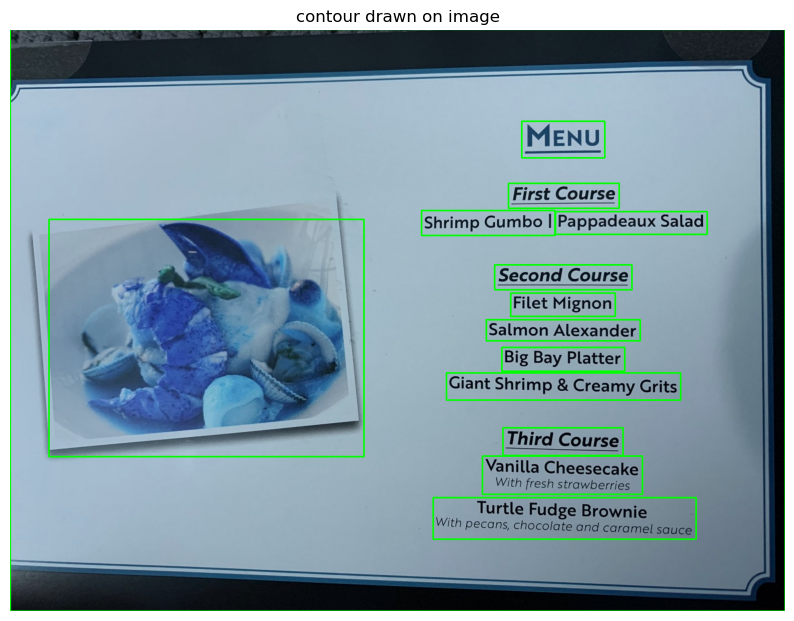

In [83]:
img1 = cv.imread("test_file/test.jpeg")
words_list = []

dil_img = pre_process(img1)

output_doc = fitz.open()
page = output_doc.new_page(width=img1.shape[1], height=img1.shape[0])  # make page in target Document

(cnt, heirarchy) = cv.findContours(dil_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
sorted_contour_lines = sorted(cnt, key=lambda cntr : cv.boundingRect(cntr)[1])

for line in sorted_contour_lines:
    # roi of each line
    x, y, w, h = cv.boundingRect(line)
    roi_line = dil_img[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv.findContours(roi_line.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv.boundingRect(cntr)[0])
    # print(sorted_contour_words)
    
    for word in sorted_contour_words:
        if cv.contourArea(word) > 700:
            x2, y2, w2, h2 = cv.boundingRect(word)
            words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
            cv.rectangle(img1, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0,255,0),2)
    break
        
plt.figure(figsize=(10,8))
plt.imshow(img1);plt.title("contour drawn on image");plt.axis("off")
plt.show()

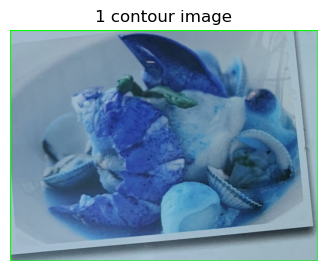

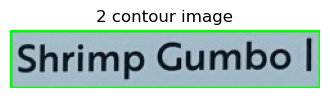

Shrimp Gumbo |



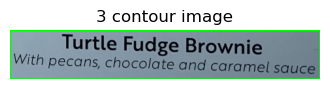

Turtle Fudge Brownie
With pecans, chocolate and caramel sauce




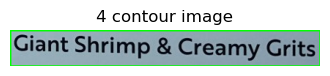

Giant Shrimp & Creamy Grits




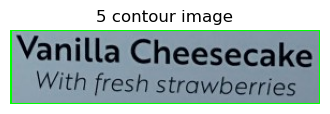

la Cheesecake
With fresh strawberries




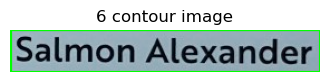

Salmon Alexander



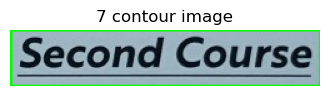

Second Course



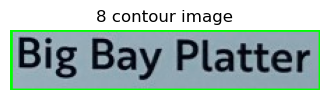

Big Bay Platter



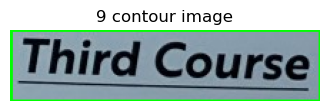

Third Course



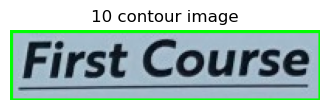

First Course



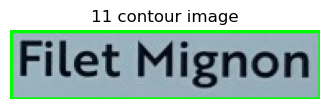

Filet Mignon



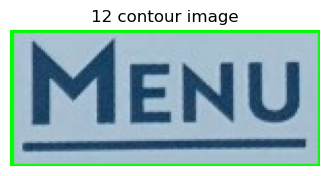

MENU



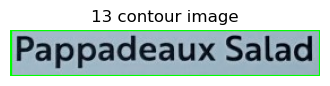

Pappadeaux Salad



In [84]:
custom_config = r'-l nep+eng --oem 3 --psm 1'

output_doc = fitz.open()
page = output_doc.new_page(width=img1.shape[1], height=img1.shape[0])  # make page in target Document

sorted_word_lists = sorted(words_list)
for i in range(1, len(sorted_word_lists)):
    word = words_list[i]
    image = img1[word[1]:word[3], word[0]:word[2]]
    
    text = pt.image_to_string(image, config=custom_config)
    
    plt.figure(figsize=(4,3))
    plt.imshow(image);plt.title(f"{i} contour image");plt.axis("off")
    plt.show()
    
    print(text)

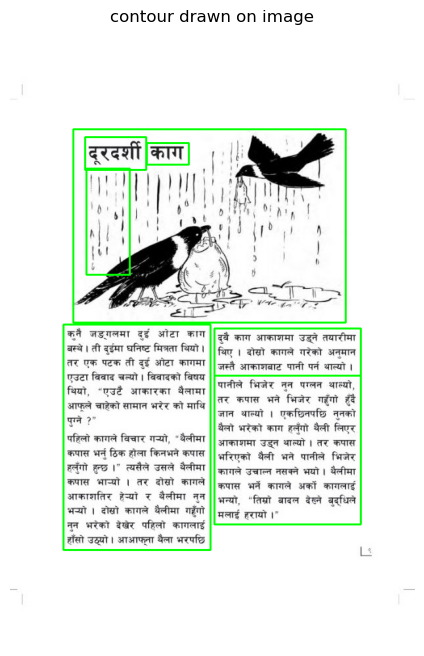

In [122]:
img3 = cv.imread("test_file/test1.jpeg")
words_list = []
dil_img1 = pre_process(img3)

(contours, heirarchy) = cv.findContours(dil_img1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv.boundingRect(ctr)[1])

for line in sorted_contours_lines:    
    # roi of each line
    x, y, w, h = cv.boundingRect(line)
    roi_line = dil_img1[y:y+w, x:x+w]
    
    # draw contours on each word
    (cnt, heirarchy) = cv.findContours(roi_line, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    sorted_contour_words = sorted(cnt, key=lambda cntr : cv.boundingRect(cntr)[0])
    
#     for word in sorted_contour_words:
#         x2, y2, w2, h2 = cv.boundingRect(word)
        
    if cv.contourArea(line) > 1500:
        words_list.append([x, y, x+w, y+h])
        cv.rectangle(img3, (x, y), (x+w, y+h), (0,255,0),2)

plt.figure(figsize=(10,8))
plt.imshow(img3);plt.title("contour drawn on image");plt.axis("off")
plt.show()

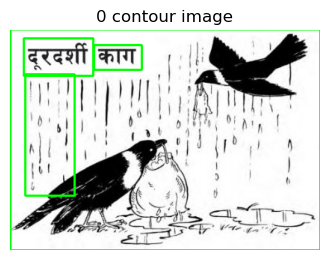

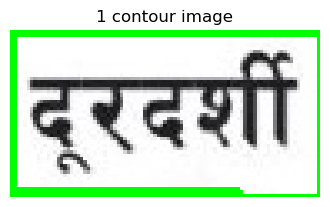

दूरदर्शी



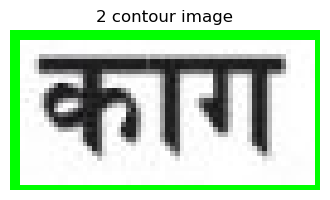

काग



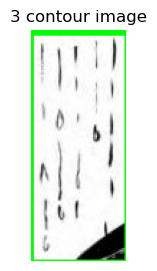

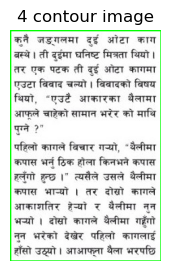

कुनै जङ्गलमा दुई ओटा काग
बस्थे । ती दुईमा घनिष्ट मित्रता थियौ ।
तर एक पटक ती दुई ओटा कागमा
एउटा विवाद चल्यो । विवादको विषय
थियो, “एउटै आकारका थैलामा
आफूले चाहेको सामान भरेर को माथि
पुग्ने ?”

पहिलो कागले विचार गन्यो, “यैलीमा
कपास भर्नु ठिक हौला किनभने कपास
हलुँगो हुन्छ ।” त्यसैले उसले यैलीमा
कपास भान्यो । तर दोसरो कागले
आकाशतिर हेत्यो र बैलीमा नुन
भन्यो । दोसो कागले थैलीमा गहुँगो
नुन भरेको देखेर पहिलौ कागलाई
हाँसो उठ्यो । आआफूना बैला भरपछि




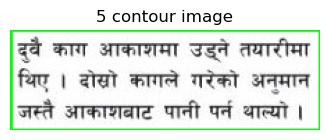

दुवै काग आकाशमा उड्ने तयारीमा
थिए । दोस्रो कागले गरेको अनुमान
जस्तै आकाशबाट पानी पर्न थाल्यो ।




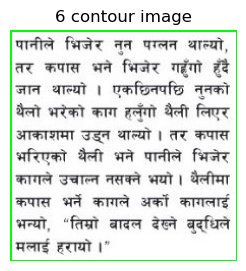

पानीले भिजेर नुन पग्लन थाल्यो,
तर कपास भने भिजेर गहुँगो हुँदै
जान थाल्यो । एकछिनपछि नुनको
अैलो भरेको काग हलुँगो थैली लिएर
आकाशमा उड्न थाल्यो । तर कपास
भरिएको थैली भने पानीले भिजेर
कागले उचाल्त नसक्ने भयो । बैलीमा
कपास भर्ने कागले अर्को कागलाई
भन्यो, “तिम्रो बादल देख्ने बुद्धिले
मलाई हरायो ।”




In [126]:
custom_config = r'-l nep --oem 3 --psm 1'

output_doc = fitz.open()
page = output_doc.new_page(width=img1.shape[1], height=img1.shape[0])  # make page in target Document

for i in range(0, len(words_list)):
    word = words_list[i]
    image = img3[word[1]:word[3], word[0]:word[2]]
    
    text = pt.image_to_string(image, config=custom_config)
    
    plt.figure(figsize=(4,3))
    plt.imshow(image);plt.title(f"{i} contour image");plt.axis("off")
    plt.show()
    
    print(text)
